In [7]:
# use the MLP architecture to generate new Gen-Z slang

In [19]:
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [87]:
# extract words from file
f = open("./data/gen_zz_words.csv", "r")
data = f.readlines()
data = data[1:]
words = [line.split(',')[0].lower() for line in data]
chars = sorted(list(set(''.join(words))))
vocab_size = len(chars) + 1

In [88]:
# create the character map 
# use . for delimiter
itos = {}
stoi = {}
for i in range(len(chars)):
    itos[i+1] = chars[i]
    stoi[chars[i]] = i + 1

itos[0] = '.'
stoi['.'] = 0
stoi

{' ': 1,
 '-': 2,
 '0': 3,
 '1': 4,
 'a': 5,
 'b': 6,
 'c': 7,
 'd': 8,
 'e': 9,
 'f': 10,
 'g': 11,
 'h': 12,
 'i': 13,
 'j': 14,
 'k': 15,
 'l': 16,
 'm': 17,
 'n': 18,
 'o': 19,
 'p': 20,
 'r': 21,
 's': 22,
 't': 23,
 'u': 24,
 'v': 25,
 'w': 26,
 'x': 27,
 'y': 28,
 'z': 29,
 '.': 0}

In [89]:
# our training, val, and test splits
# X = array of arrays of length block_size (the contexts as integers)
# Y = the integer representation of the target
n = len(words)

# 80, 10, 10 split
train_data = words[:int(0.8*n)]
val_data = words[int(0.8*n):int(0.9*n)]
test_data = words[int(0.9 *n):]

xtr, ytr = [], []
xval, yval = [], []
xtest, ytest = [], []

block_size = 3
for word in train_data:
    for i, ch in enumerate(word + "."):
        context = [0] * block_size
        for j in range(-1 * block_size, 0):
            if i + j >= 0:
                context[j + block_size] = stoi[word[i+j]]

        xtr.append(context)
        ytr.append(stoi[ch])

for word in val_data:
    for i, ch in enumerate(word + "."):
        context = [0] * block_size
        for j in range(-1 * block_size, 0):
            if i + j >= 0:
                context[j + block_size] = stoi[word[i+j]]

        xval.append(context)
        yval.append(stoi[ch])

for word in test_data:
    for i, ch in enumerate(word + "."):
        context = [0] * block_size
        for j in range(-1 * block_size, 0):
            if i + j >= 0:
                context[j + block_size] = stoi[word[i+j]]

        xtest.append(context)
        ytest.append(stoi[ch])
    

xtr, ytr = torch.tensor(xtr), torch.tensor(ytr)
xval, yval = torch.tensor(xval), torch.tensor(yval)
xtest, ytest = torch.tensor(xtest), torch.tensor(ytest)
xtr.shape, ytr.shape

(torch.Size([1092, 3]), torch.Size([1092]))

In [90]:
g = torch.Generator().manual_seed(2024)
lower_dims = 2
hidden_size = 20
C = torch.randn(vocab_size, lower_dims, generator=g)
W1 = torch.randn(block_size * lower_dims, hidden_size, generator=g)
b1 = torch.randn(hidden_size, generator=g)
W2 = torch.randn(hidden_size, vocab_size, generator=g)
b2 = torch.randn(vocab_size, generator=g)
params = [C, W1, b1, W2, b2]

for p in params:
    p.requires_grad = True

sum(p.nelement() for p in params)

830

In [91]:
iterations = 10000
mini_batch_size = 50
for _ in range(iterations):
    # construct a minibatch
    ix = torch.randint(0, xtr.shape[0], (mini_batch_size,), generator=g)
    # forward pass
    # build the embedding table (1st layer) 
    # size = len(chars) = 29 x num_dims 
    emb = C[xtr[ix]]
    # build the hidden layer
    h = torch.tanh(emb.view(-1, block_size * lower_dims) @ W1 + b1)
    # build the output layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, ytr[ix])
    
    # backward pass
    for p in params:
        p.grad = None
    
    loss.backward()
    lr = 0.01
    for p in params:
        p.data += -1 * lr * p.grad

print(loss.item())

2.493741989135742


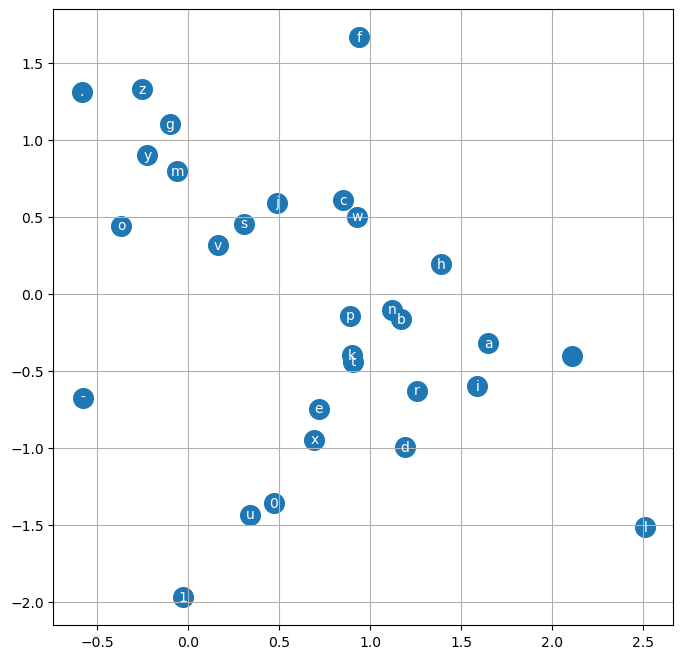

In [92]:
# visualize embeddings 
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [93]:
emb = C[xval]
h = torch.tanh(emb.view(-1, block_size * lower_dims) @ W1 + b1)
logits = h @ W2 + b2
loss_val = F.cross_entropy(logits, yval)
loss_val

tensor(2.6489, grad_fn=<NllLossBackward0>)

In [94]:
# sample from model
for i in range(20):
    context = [0] * block_size
    out = []
    while True:
        emb=C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break

    print(''.join(out))
        

bailu.
taghee.
bopet.
flitsuer.
theae.
ploejt.
chlnp.
jlay ricll.
modep.
thiu.
oshaee.
dep.
dead.
o.
som.
slle.
vceg rck.
ao.
sylme.
ggglat.
